# Franklin Prima Portfolio at the turn

In our notebook on [mutal fund drawdowns](https://github.com/stockviz/plutons/blob/master/mutual-fund-drawdown.R.ipynb), we saw how Franklin India Prima Fund drew down the least compared to other large midcap mutual funds. How did the portfolio change through time?

In [1]:
library(DBI)
library(plutoDbR)
library(plutoR)
library(tidyverse)
options("scipen"=999)
options(stringsAsFactors = FALSE)
source("/usr/share/pluto/config.R")
source("/usr/share/pluto/goofy/plot.common.R")
source("/usr/share/pluto/goofy/misc.common.R")

library(ggthemes)
library(quantmod)
library(PerformanceAnalytics)

options(repr.plot.width=16, repr.plot.height=8)

indices <- Indices()
mfi <- MutualFundsIndia()

### The big picture

How did the fund perform over the Midcap 150 TR index over a 5 year period?

In [2]:
indexName <- "NIFTY MIDCAP 150 TR"
schemeCode <- 100473
schemeName <- "Franklin India Prima"
startDate <- as.Date("2014-01-01")
endDate <- as.Date("2019-08-31")

In [3]:
#get the daily returns of the fund
navs <- mfi$NavTimeSeries() %>%
        filter(SCHEME_CODE == schemeCode & TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
        select(TIME_STAMP, NAV) %>%
        collect() %>%
        mutate(TIME_STAMP=as.Date(TIME_STAMP))

navXts <- dailyReturn(xts(navs$NAV, navs$TIME_STAMP))

#grab the benchmark
bm <- indices$NseTimeSeries() %>%
        filter(NAME == indexName & TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
        select(TIME_STAMP, CLOSE) %>%
        collect() %>%
        mutate(TIME_STAMP = as.Date(TIME_STAMP))

navXts <- merge.xts(navXts, dailyReturn(xts(bm$CLOSE, bm$TIME_STAMP)))
names(navXts) <- c("FUND", indexName)

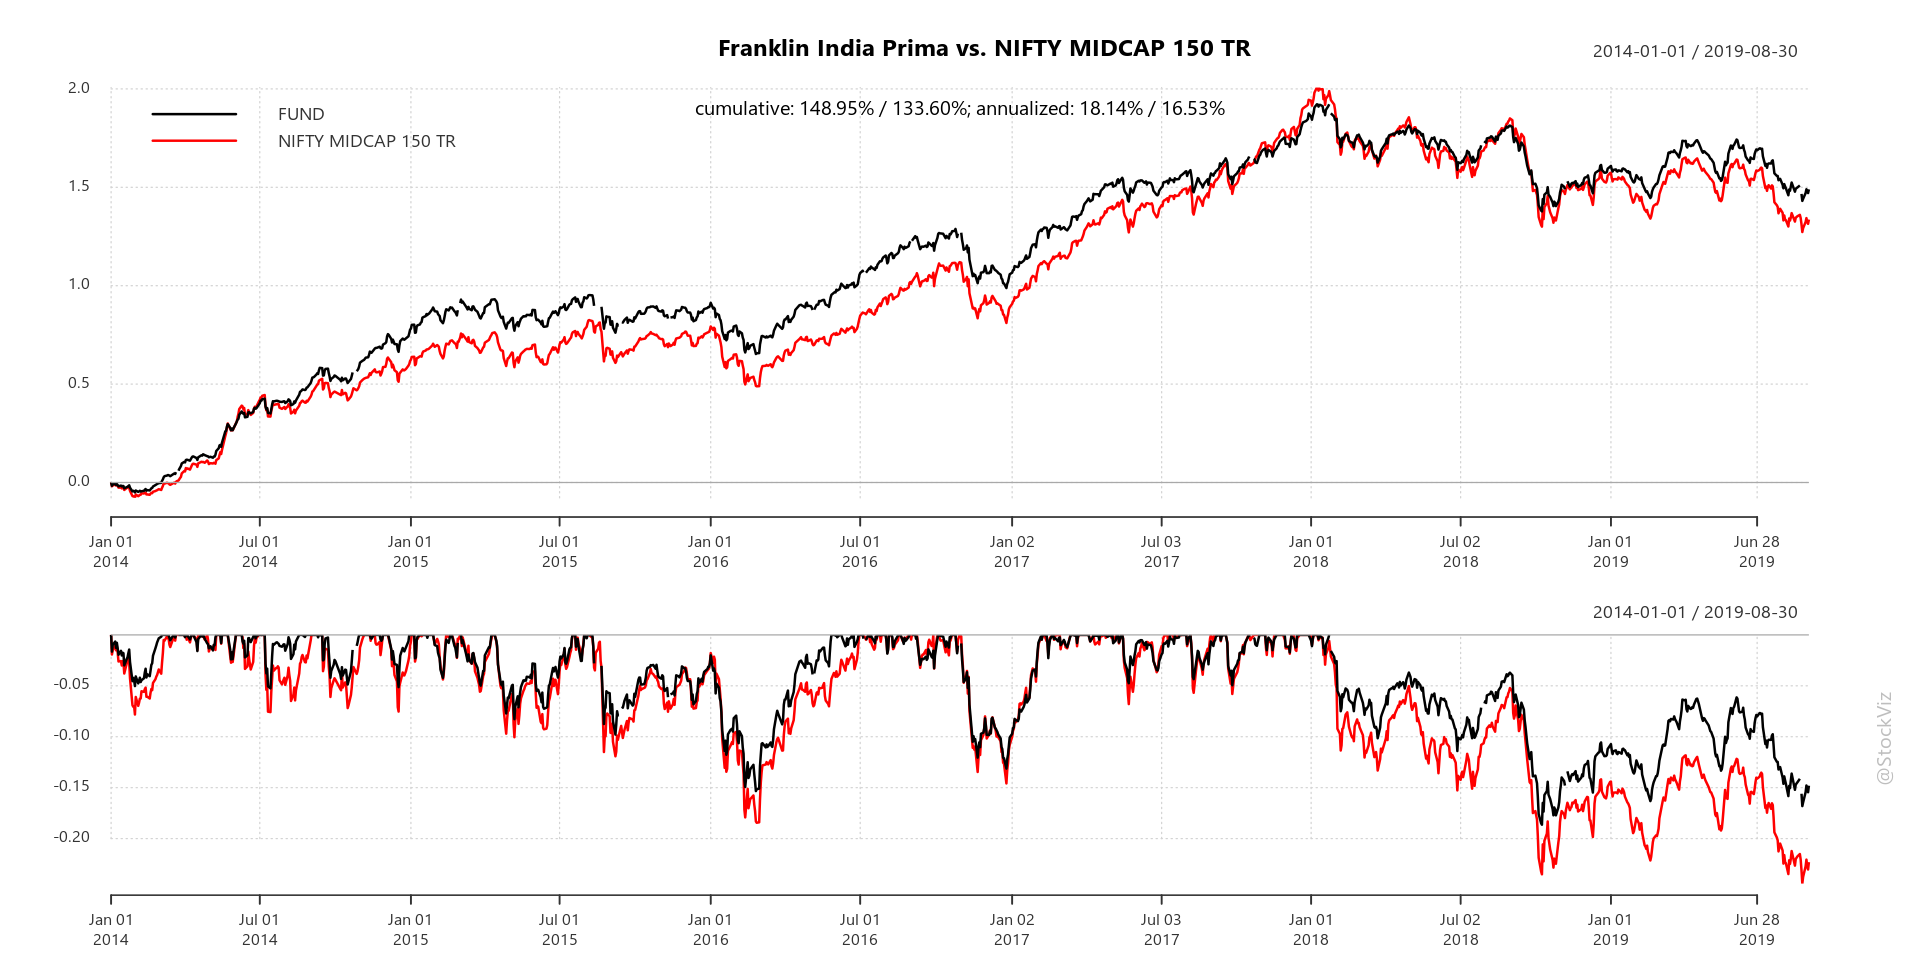

In [4]:
# plot the cumulative returns
Common.PlotCumReturns(navXts, sprintf("%s vs. %s", schemeName, indexName), "")

### How was the fund positioned going into 2018 vs. where it was in March 2019?

In [5]:
date1 <- as.Date("2017-12-31")
date2 <- as.Date("2019-03-31")

sectorAlloc1 <- mfi$Portfolio() %>%
    filter(SCHEME_CODE == schemeCode 
           & INSTRUMENT == 'EQUITY' 
           & !is.null(WEIGHTAGE)
           & WEIGHTAGE > 0
           & PORTFOLIO_DATE == date1
           & (INSTRUMENT_TYPE == 'STOCK' 
              | INSTRUMENT_TYPE == 'E' 
              | INSTRUMENT_TYPE == '' 
              | is.null(INSTRUMENT_TYPE))) %>%
    group_by(INDUSTRY_BSE) %>%
    summarize(ALLOC = sum(WEIGHTAGE)) %>%
    arrange(desc(ALLOC)) %>%
    collect()

sectorAlloc1Df <- sectorAlloc1 %>%
    mutate(INDUSTRY_BSE = replace(INDUSTRY_BSE, INDUSTRY_BSE == '-' 
                                  | is.na(INDUSTRY_BSE), 'UNK')) %>%
    as.data.frame()

sectorAlloc2 <- mfi$Portfolio() %>%
    filter(SCHEME_CODE == schemeCode 
           & INSTRUMENT == 'EQUITY' 
           & !is.null(WEIGHTAGE)
           & WEIGHTAGE > 0
           & PORTFOLIO_DATE == date2
           & (INSTRUMENT_TYPE == 'STOCK' 
              | INSTRUMENT_TYPE == 'E' 
              | INSTRUMENT_TYPE == '' 
              | is.null(INSTRUMENT_TYPE))) %>%
    group_by(INDUSTRY_BSE) %>%
    summarize(ALLOC = sum(WEIGHTAGE)) %>%
    arrange(desc(ALLOC)) %>%
    collect()

sectorAlloc2Df <- sectorAlloc2 %>%
    mutate(INDUSTRY_BSE = replace(INDUSTRY_BSE, INDUSTRY_BSE == '-' 
                                  | is.na(INDUSTRY_BSE), 'UNK')) %>%
    as.data.frame()


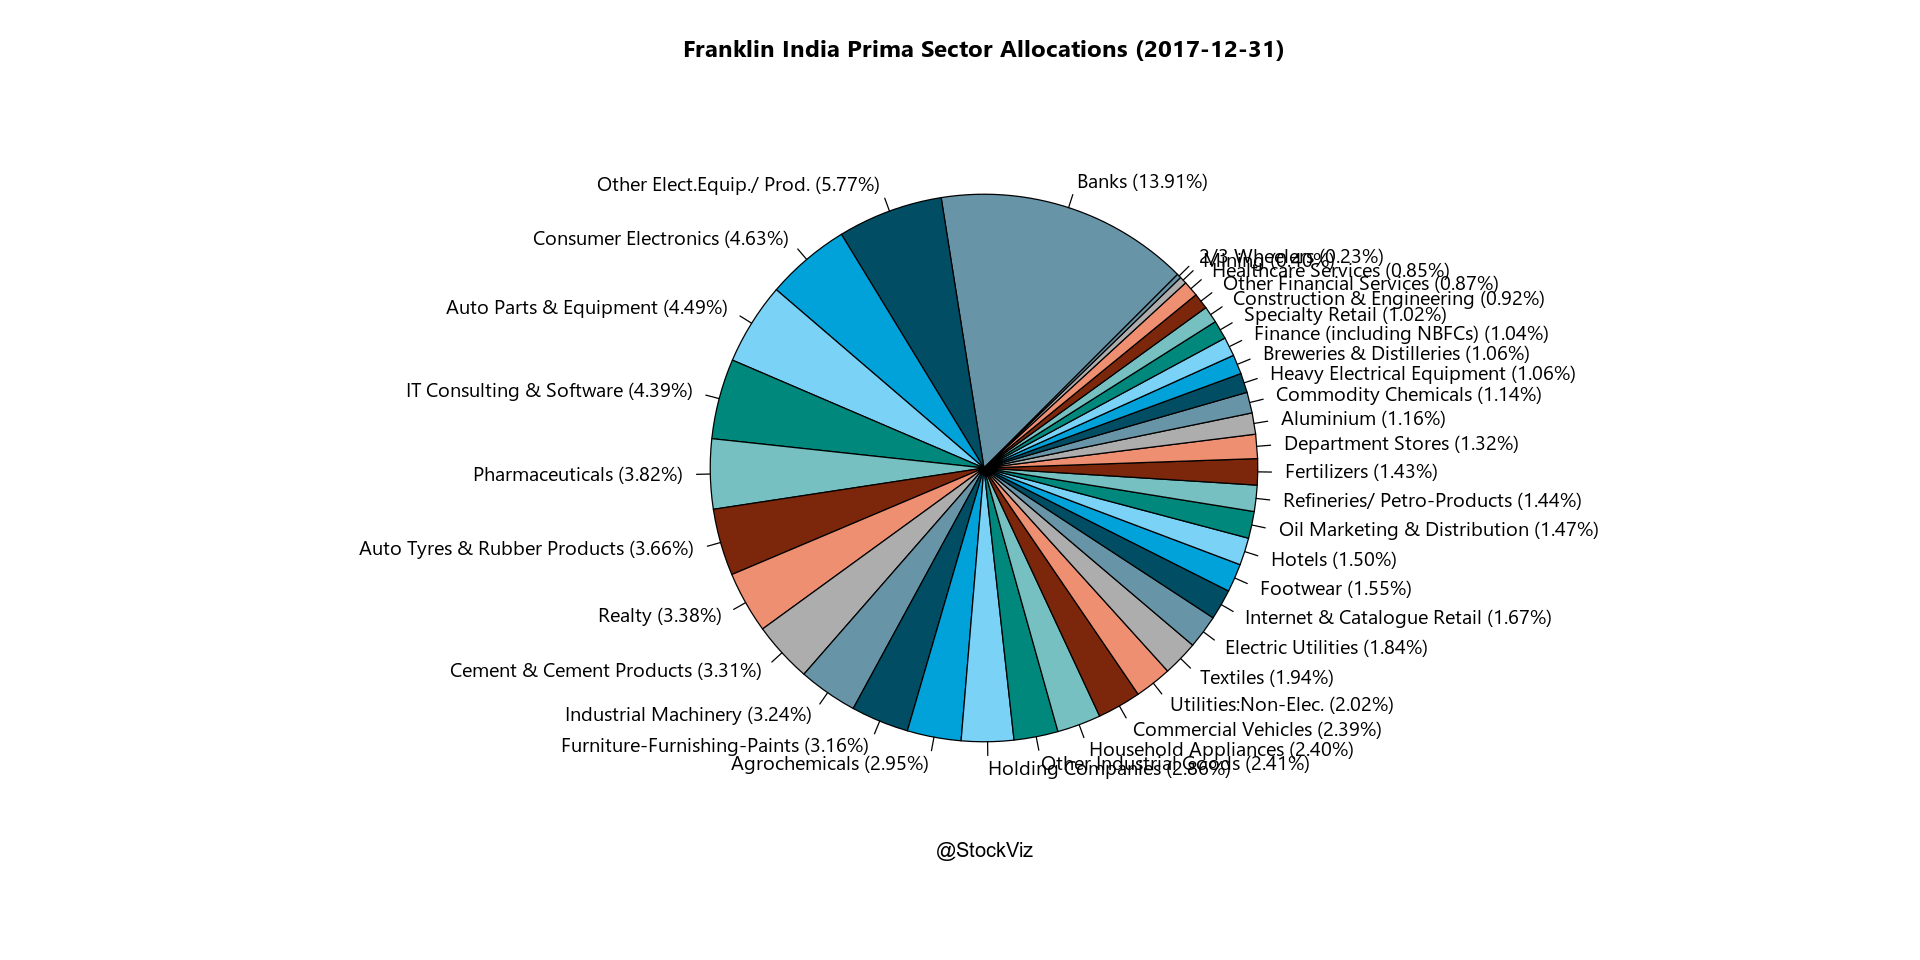

In [6]:
pie(sectorAlloc1Df$ALLOC, labels=sprintf("%s (%.2f%%)", sectorAlloc1Df$INDUSTRY, sectorAlloc1Df$ALLOC), 
    col=economist_pal()(9), 
    main=sprintf("%s Sector Allocations (%s)", schemeName, date1), 
    family='Segoe UI', 
    init.angle=45)
mtext("@StockViz", side=1)

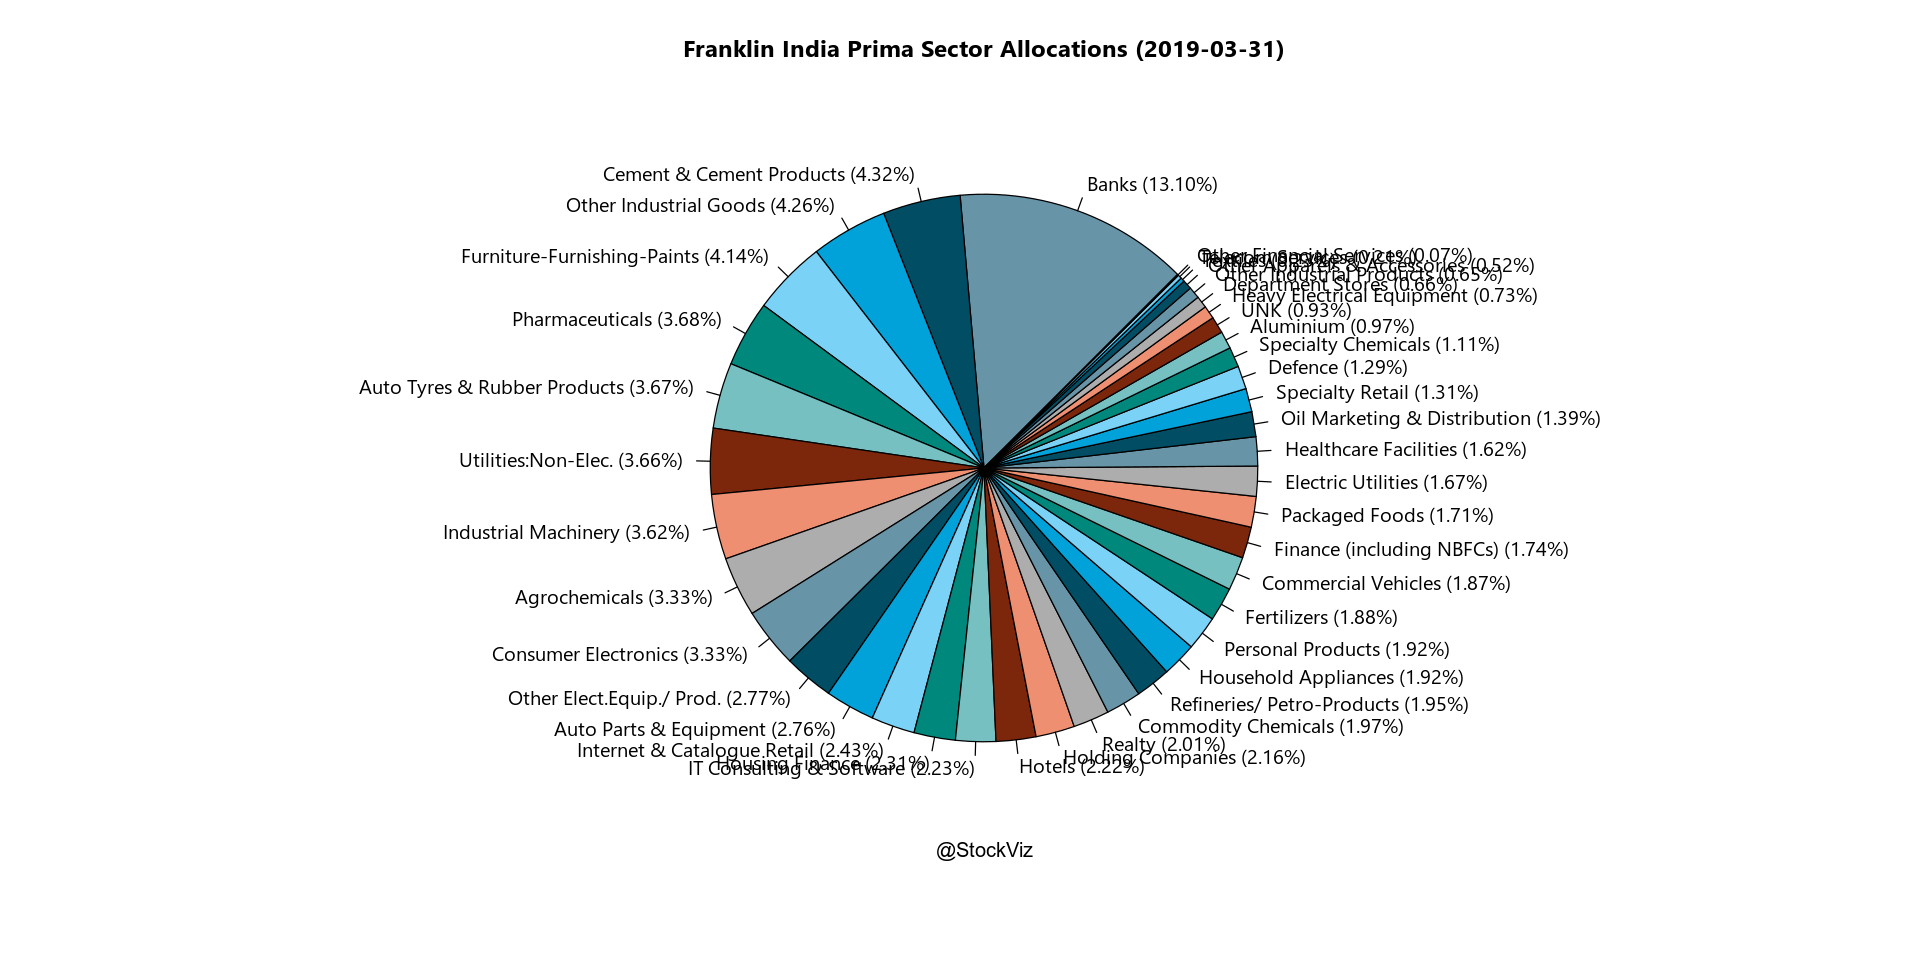

In [7]:
pie(sectorAlloc2Df$ALLOC, labels=sprintf("%s (%.2f%%)", sectorAlloc2Df$INDUSTRY, sectorAlloc2Df$ALLOC), 
    col=economist_pal()(9), 
    main=sprintf("%s Sector Allocations (%s)", schemeName, date2), 
    family='Segoe UI', 
    init.angle=45)
mtext("@StockViz", side=1)

In [8]:
# zoom into allocations that are more than 2%

sectorAlloc1Df2 <- sectorAlloc1Df[sectorAlloc1Df$ALLOC > 2, ]
sectorAlloc2Df2 <- sectorAlloc2Df[sectorAlloc2Df$ALLOC > 2, ]

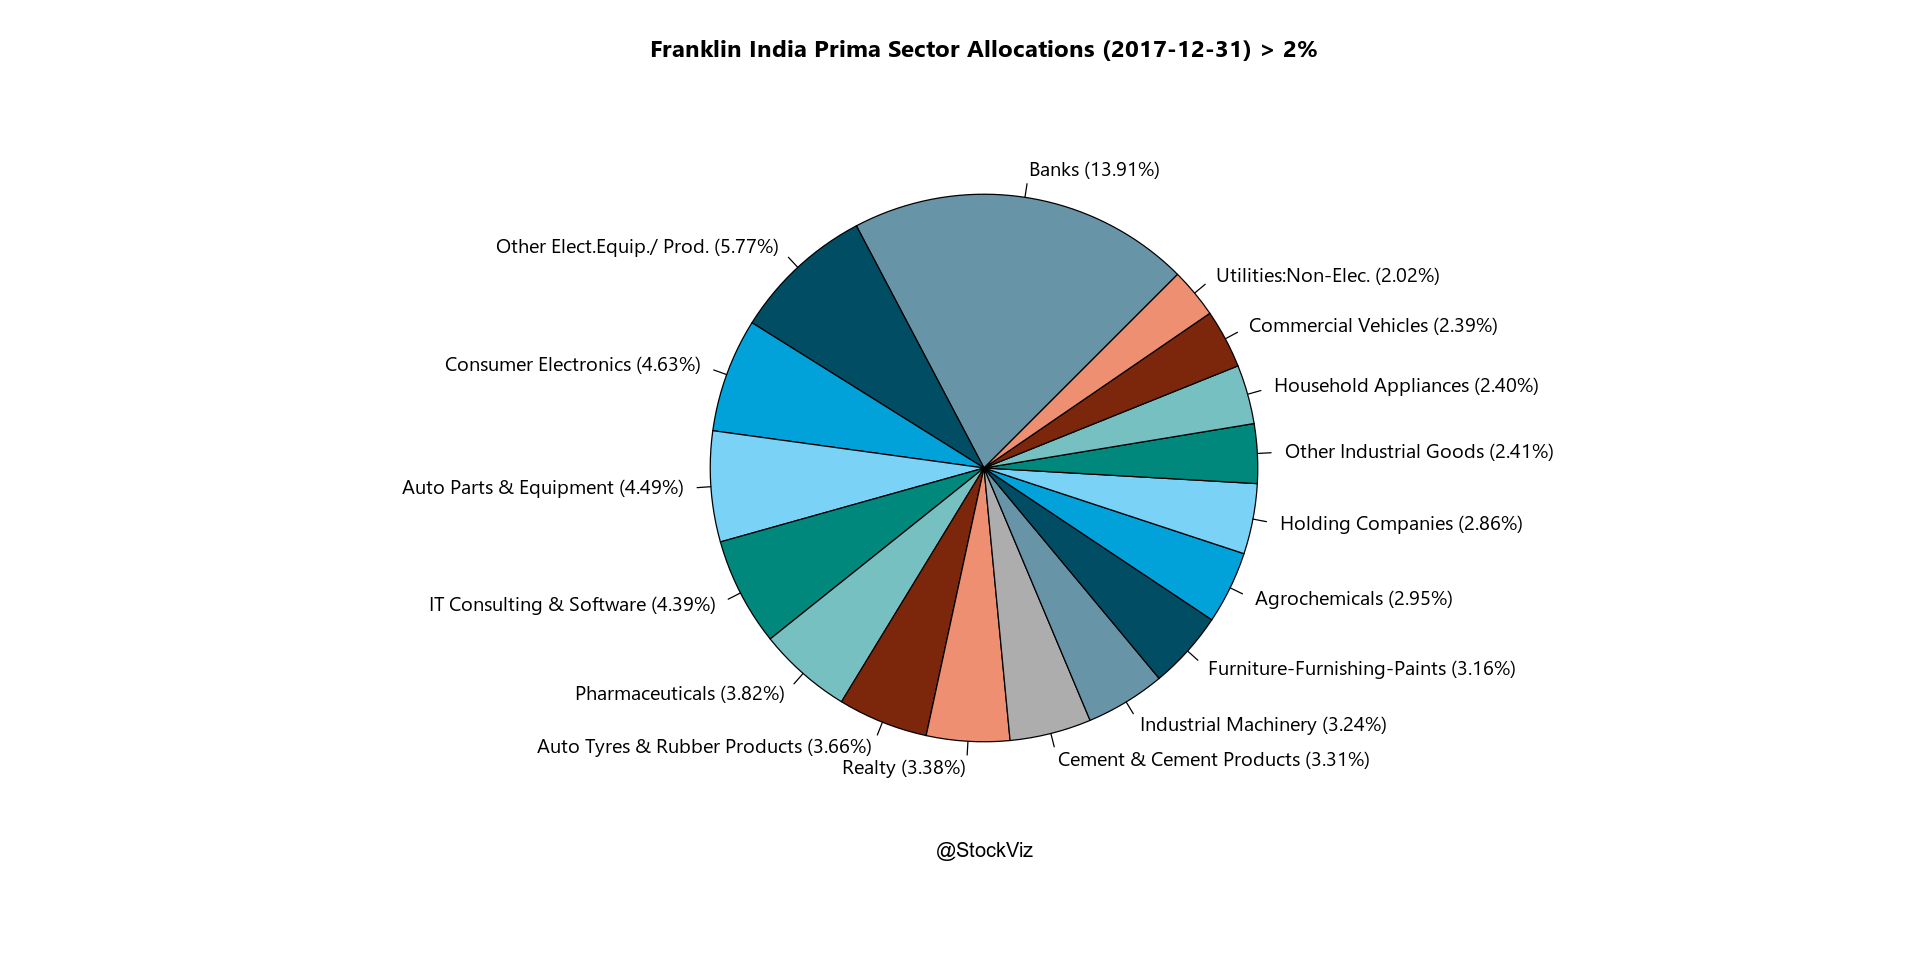

In [9]:
pie(sectorAlloc1Df2$ALLOC, labels=sprintf("%s (%.2f%%)", sectorAlloc1Df2$INDUSTRY, sectorAlloc1Df2$ALLOC), 
    col=economist_pal()(9), 
    main=sprintf("%s Sector Allocations (%s) > 2%%", schemeName, date1), 
    family='Segoe UI', 
    init.angle=45)
mtext("@StockViz", side=1)

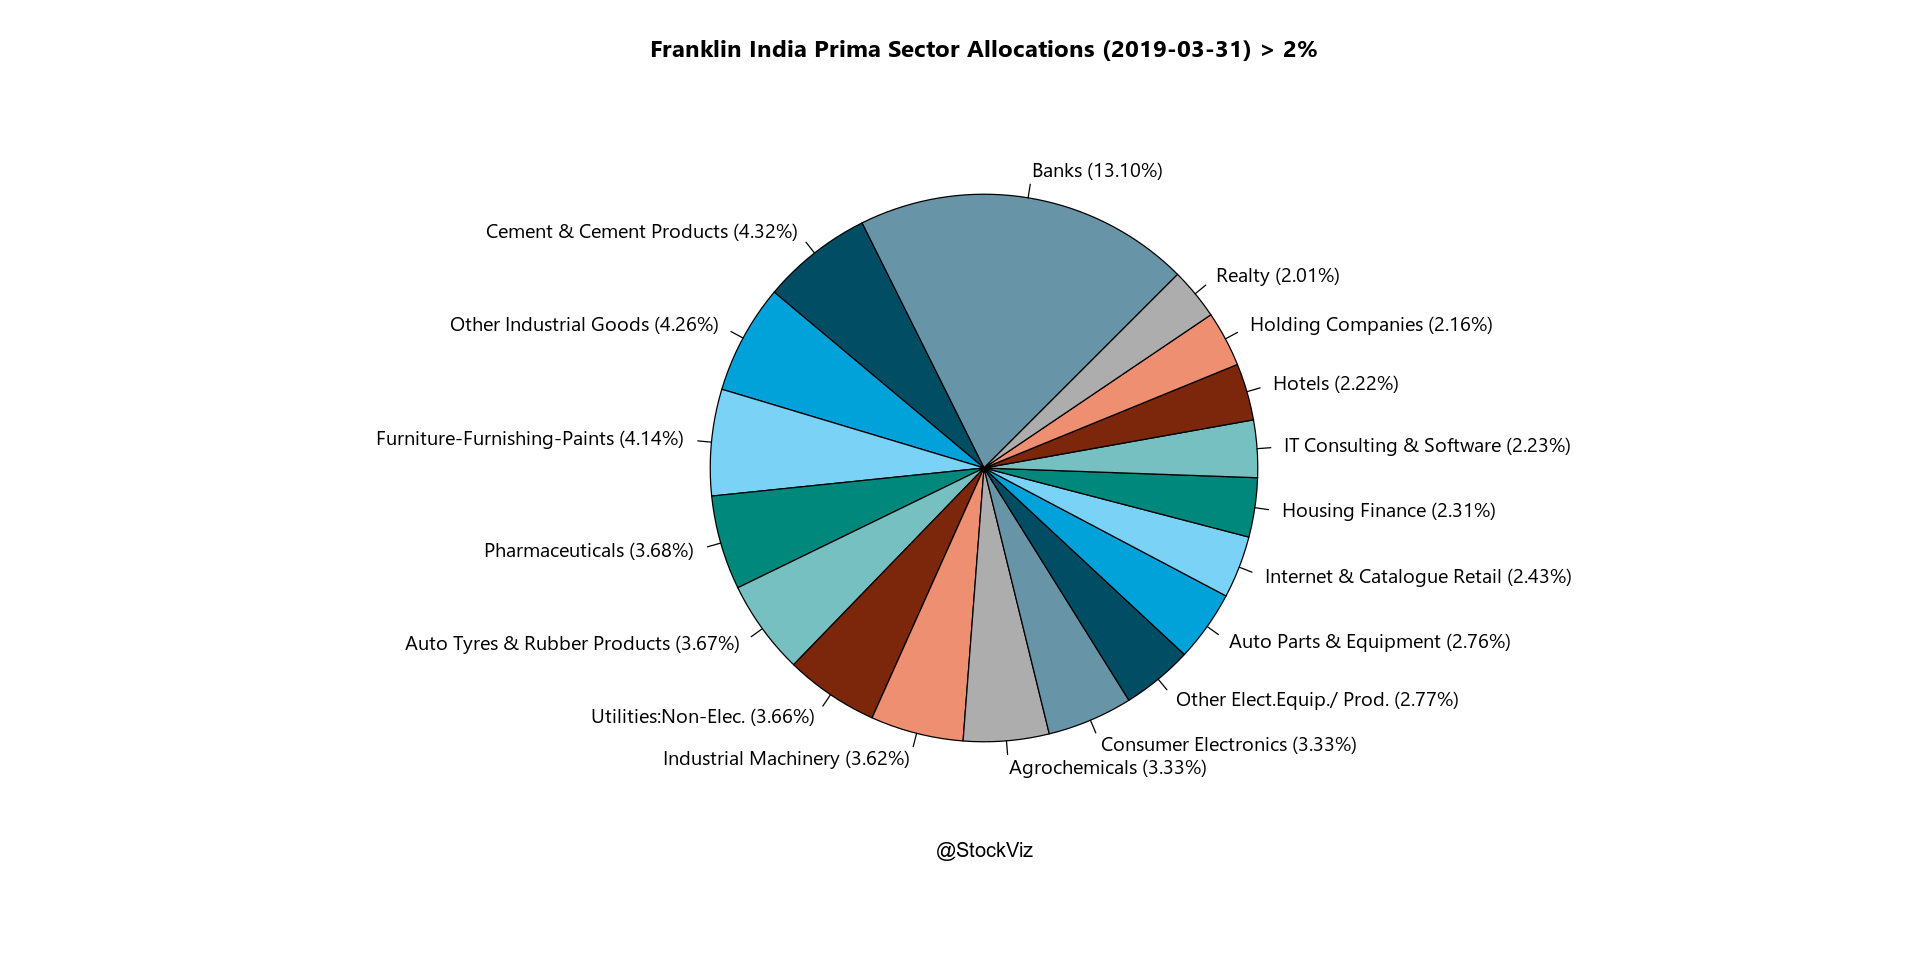

In [10]:
pie(sectorAlloc2Df2$ALLOC, labels=sprintf("%s (%.2f%%)", sectorAlloc2Df2$INDUSTRY, sectorAlloc2Df2$ALLOC), 
    col=economist_pal()(9), 
    main=sprintf("%s Sector Allocations (%s) > 2%%", schemeName, date2), 
    family='Segoe UI', 
    init.angle=45)
mtext("@StockViz", side=1)

This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)